## CartPole with Q-learning

Q-learning is a off-policy temporal-difference method that uses the following update:
$$Q(S_t, A_t) \gets Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma max_a Q(S_t+1, a) - Q(S_t, A_t) \right]$$

where $Q(S_t, A_t)$ is the value of taking action $A_t$ in state $S_t$, $\alpha$ is the step-size (learning rate) and $R_{t+1}$ is the reward received. We update $Q(S_t, A_t)$ using the direct reward received plus the reward we expect to receive in future. The update can be seen as optimistic because we take the maximum expected return.

The objective of the CartPole problem (from OpenAI gym: https://gym.openai.com/envs/CartPole-v0) is to teach the cart to balance a pole by applying a horizontal force to the left or right. An episode ends when the pole tips more than 15 degrees from the vertical or the cart moves more than 2.4 units from the center. In smaller problems like Grid World, a table could be used to store all possible combinations of states and actions. In more complex problems, especially those with continuous states or actions, it is impossible to completely represent all state and action pairs so an approximator (neural network) is used. The input to the neural network is a state and the output is the value of all actions (we can then choose to take the action with the highest value if we're following $\epsilon$-greedy action selection for example).

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import cntk
from cntk import *
from cntk.layers import *

In [2]:
def predict(Q, state):
    """
    The predict function takes the model (our network) and a state, feeds the state 
    through the model and obtains the values of each action:
    """
    return Q.eval([state.astype(np.float32)])[0][0]

Once again we are using $\epsilon$-greedy action selection. We generate a random number and if it is above our threshold, $\epsilon$, we pick a random action (explore), otherwise, we use the output of our model (exloit current knowledge). The action with the highest value is selected (greedy).

In [3]:
def epoch_greedy(Q, epsilon, state, action_count):
    """
    Selects an action using the epoch-greedy approach
    """
    prob = np.random.randn(1)
    if prob > epsilon:
        # exploit (greedy)
        action_index = np.argmax(predict(Q, state))
    else:
        # explore (random action)
        action_index = np.random.randint(0, action_count)
    
    return action_index

I have randomly chosen to use 2 hidden layers, both with 16 neurons and using ReLu (Rectified Linear Unit) activation. The input shape depends on the shape of the state and the output shape depends on the number of actions. I calculate the loss as the mean of the square difference between the actual outputs and the expected outputs and have chosen to use a learning rate of 0.0025 and stochastic gradient descent for learning.

For each step of an episode, we select an action (using $\epsilon$-greedy action selection) and then execute it yielding the next state and reward as well as a boolean indicating if the next state is terminal. We then calculate the expected return as the sum of the received reward plus the discounted future reward (0 if terminal). The current state serves as our input and the expected return serves as the label (truth value) for the neural network. Finally, I store the reward for each episode so we can monitor the progress.

In [4]:
def train(env, episodes, gamma, epsilon_fn):
    """
    param env: The gym environment to train with
    param episodes: The number of episodes to train for
    param gamma: The discount factor
    param epsilon_fn: Function which returns epsilon for epoch-greedy learning
    """
    input_dim = env.observation_space.shape
    output_dim = env.action_space.n

    input_var = input_variable(input_dim, np.float32)
    output_var = input_variable(output_dim, np.float32)

    model = Sequential([
        Dense(16, activation=relu, name='dense1'),
        Dense(16, activation=relu, name='dense2'),
        Dense(output_dim, name='z')
    ])(input_var)
    
    loss = reduce_mean(square(model.z - output_var), axis=0)

    learning_rate = 0.0025
    lr_schedule = learning_rate_schedule(learning_rate, UnitType.sample)
    learner = sgd(model.z.parameters, lr_schedule)
    printer = cntk.logging.ProgressPrinter(tag='Training')
    trainer = Trainer(model.z, loss, learner, printer)    
    
    episode = 0
    rewards = 0
    episode_rewards = []
    s = env.reset()
    
    while episode < episodes:
        # Select action using policy derived from Q (e-greedy) 
        a = epoch_greedy(model, epsilon_fn(episode), s, output_dim)

        # Take action and observe next state and reward
        s_, r, done, info = env.step(a)

        y = predict(model, s)
        if done:
            y[a] = r
        else:
            y[a] = r + gamma * np.amax(predict(model, s_))

        trainer.train_minibatch({input_var: s.astype(np.float32), output_var: y.astype(np.float32)})

        s = s_
        rewards += r

        # Episode over, reset environment
        if done:                
            episode += 1
            episode_rewards.append(rewards)

            if episode % 200 == 0:
                print('Episode {}, reward = {}'.format(episode, rewards))
                # trainer.summarize_training_progress()

            s = env.reset()
            rewards = 0
    return model, episode_rewards

I have decided to train for 10k episodes using a discount factor of 0.99 and epsilon value of 0.1. To see the effects of a constant versus decaying epsilon (value reduces with time), I've trained two models using 2 separate epsilon functions:

In [5]:
# Fixed value epsilon
def constant_epsilon(episode):
    return 0.1

In [6]:
# epsilon starts with 1 and decays to a minimum of 0.05
# decay factor was chosen such that the value of epsilon is 0.05 by episode 8000
def decaying_epsilon(episode):
    return max(math.exp(-3.74e-4 * episode), 0.05)

In [7]:
gamma = 0.99
episodes = 10000
env = gym.make('CartPole-v0')

[2017-04-19 13:17:56,883] Making new env: CartPole-v0


In [8]:
model1, rewards1 = train(env, episodes, gamma, constant_epsilon)

Episode 200, reward = 8.0
Episode 400, reward = 10.0
Episode 600, reward = 13.0
Episode 800, reward = 27.0
Episode 1000, reward = 14.0
Episode 1200, reward = 13.0
Episode 1400, reward = 54.0
Episode 1600, reward = 19.0
Episode 1800, reward = 12.0
Episode 2000, reward = 39.0
Episode 2200, reward = 74.0
Episode 2400, reward = 44.0
Episode 2600, reward = 13.0
Episode 2800, reward = 23.0
Episode 3000, reward = 46.0
Episode 3200, reward = 26.0
Episode 3400, reward = 71.0
Episode 3600, reward = 18.0
Episode 3800, reward = 36.0
Episode 4000, reward = 36.0
Episode 4200, reward = 30.0
Episode 4400, reward = 25.0
Episode 4600, reward = 85.0
Episode 4800, reward = 21.0
Episode 5000, reward = 32.0
Episode 5200, reward = 77.0
Episode 5400, reward = 39.0
Episode 5600, reward = 73.0
Episode 5800, reward = 28.0
Episode 6000, reward = 44.0
Episode 6200, reward = 54.0
Episode 6400, reward = 39.0
Episode 6600, reward = 58.0
Episode 6800, reward = 33.0
Episode 7000, reward = 72.0
Episode 7200, reward = 41

In [9]:
model2, rewards2 = train(env, episodes, gamma, decaying_epsilon)

Episode 200, reward = 28.0
Episode 400, reward = 10.0
Episode 600, reward = 12.0
Episode 800, reward = 10.0
Episode 1000, reward = 23.0
Episode 1200, reward = 15.0
Episode 1400, reward = 14.0
Episode 1600, reward = 26.0
Episode 1800, reward = 23.0
Episode 2000, reward = 26.0
Episode 2200, reward = 16.0
Episode 2400, reward = 53.0
Episode 2600, reward = 50.0
Episode 2800, reward = 39.0
Episode 3000, reward = 19.0
Episode 3200, reward = 24.0
Episode 3400, reward = 32.0
Episode 3600, reward = 16.0
Episode 3800, reward = 41.0
Episode 4000, reward = 26.0
Episode 4200, reward = 30.0
Episode 4400, reward = 69.0
Episode 4600, reward = 50.0
Episode 4800, reward = 30.0
Episode 5000, reward = 65.0
Episode 5200, reward = 98.0
Episode 5400, reward = 61.0
Episode 5600, reward = 52.0
Episode 5800, reward = 41.0
Episode 6000, reward = 35.0
Episode 6200, reward = 57.0
Episode 6400, reward = 20.0
Episode 6600, reward = 31.0
Episode 6800, reward = 39.0
Episode 7000, reward = 26.0
Episode 7200, reward = 7

For visual comparison of learning with time, I have plotted the moving averages of the received rewards below:

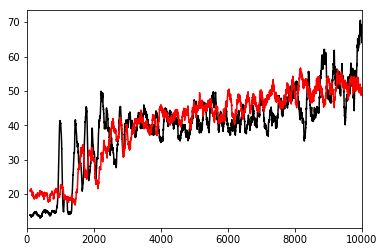

In [16]:
pd.Series(rewards1).rolling(window=100).mean().plot(label='constant \u03b5', style='k')
pd.Series(rewards2).rolling(window=100).mean().plot(label='constant \u03b5', style='r')
plt.show()

To evaluate the final models, I've defined the evaluate function below. It simulates several episodes using a model and returns the average reward.

In [13]:
def evaluate(env, model, episodes):
    """
    Computes the average performance of the trained model over 'episodes' episodes
    """
    episode = 0
    rewards = 0
    
    while episode < episodes:
        s = env.reset()
        done = False
        while not done:
            a = np.argmax(predict(model, s))
            s, r, done, info = env.step(a)
            rewards += r
        episode += 1
    
    return rewards / float(episodes)

In [15]:
ave_constant = evaluate(env, model1, 100)
ave_decaying = evaluate(env, model2, 100)

print('Average (with constant \u03b5) = {}'.format(ave_constant))
print('Average (with decaying \u03b5) = {}'.format(ave_decaying))

Average (with constant ε) = 32.73
Average (with decaying ε) = 106.14


## Conclusion
From the plot of average reward for each model during training, we may jump and conclude that both models learn about the same and have the same performance. However, the result of evaluation over 100 episodes shows a stark difference. In practice, epsilon is usually annealed to a small value to simulate how we learn - a lot of exploration at the start but less and less as our knowledge improves.

Here I run and render an episode using the better model:

In [19]:
s = env.reset()
done = False
while not done:
    env.render()
    a = np.argmax(predict(model2, s))
    s, r, done, info = env.step(a)
    
env.close()

Obviously there is still room for improvement. You can play around with the number of layers in the network (as well as the number of neurons in each layer), a different min value for epsilon (in the exponentially decaying version), a different learner (as opposed to stochastic gradient descent), different learning rate, gamma, train for longer and so on...

## References
1. Richard S. Sutton, Andrew G. Barto (1998). Reinforcement Learning: An Introduction. MIT Press.